**Problem statement**: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
#from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from glob import glob

In [2]:
## If you are using the data by mounting the google drive, use the following :

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!unzip gdrive/MyDrive/CNN_assignment.zip

Archive:  gdrive/MyDrive/CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating: Skin ca

**Brief Summary of dataset:**

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant

The data set contains the following diseases:
- Actinic keratosis
- Basal cell carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented benign keratosis
- Seborrheic keratosis
- Squamous cell carcinoma
- Vascular lesion





In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="validation",
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
## Write your test dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed=123,
    batch_size=118,
    image_size=(img_height,img_width)
)

Found 118 files belonging to 9 classes.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)


['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

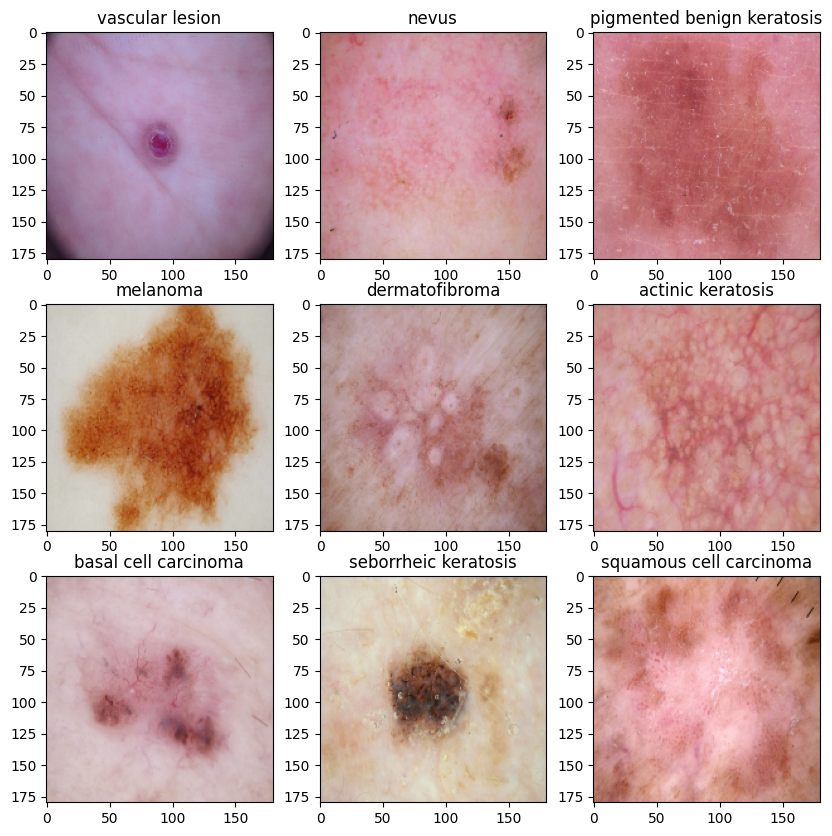

In [11]:
plot_idx=0
visited={}
visited_all=False
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(50):
  if not visited_all:
    for i in range(9):
    
      if len(visited.keys())==9:
        visited_all=True
        break
      if class_names[labels[i]] in visited.keys():
        continue
      else:
        plt.subplot(3,3,plot_idx+1)
        plt.imshow(images[i].numpy().astype("uint8"));
        plt.title(class_names[labels[i]])
        visited[class_names[labels[i]]]="Y"
        plot_idx+=1
  else:
    break

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
### Your code goes here
num_classes = 9

model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    #first conv 2d layer
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Flatten(),
                    Dense(128,activation='relu'),
                    Dense(len(class_names))
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrapp  (None, 180, 180, 64)     1792      
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 90, 90, 64)       0         
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 90, 90, 64)       0         
 pper)                                                           
                                                                 
 module_wrapper_3 (ModuleWra  (None, 90, 90, 64)       36928     
 pper)                                                  

## Train the model

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 37s 153ms/step - loss: 3.6564 - accuracy: 0.1540 - val_loss: 2.1716 - val_accuracy: 0.1790
Epoch 2/20
56/56 [==============================] - 5s 92ms/step - loss: 2.1136 - accuracy: 0.1546 - val_loss: 2.0602 - val_accuracy: 0.1790
Epoch 3/20
56/56 [==============================] - 5s 89ms/step - loss: 2.0351 - accuracy: 0.2076 - val_loss: 2.0347 - val_accuracy: 0.1924
Epoch 4/20
56/56 [==============================] - 5s 93ms/step - loss: 1.9804 - accuracy: 0.2550 - val_loss: 2.0191 - val_accuracy: 0.2125
Epoch 5/20
56/56 [==============================] - 5s 89ms/step - loss: 1.8730 - accuracy: 0.3270 - val_loss: 1.9954 - val_accuracy: 0.2461
Epoch 6/20
56/56 [==============================] - 5s 89ms/step - loss: 1.6746 - accuracy: 0.4353 - val_loss: 1.6068 - val_accuracy: 0.4877
Epoch 7/20
56/56 [==============================] - 5s 92ms/step - loss: 1.4577 - accuracy: 0.4989 - val_loss: 1.5693 - val_accuracy: 0.4832
Epoch 8/20


### Visualizing training results

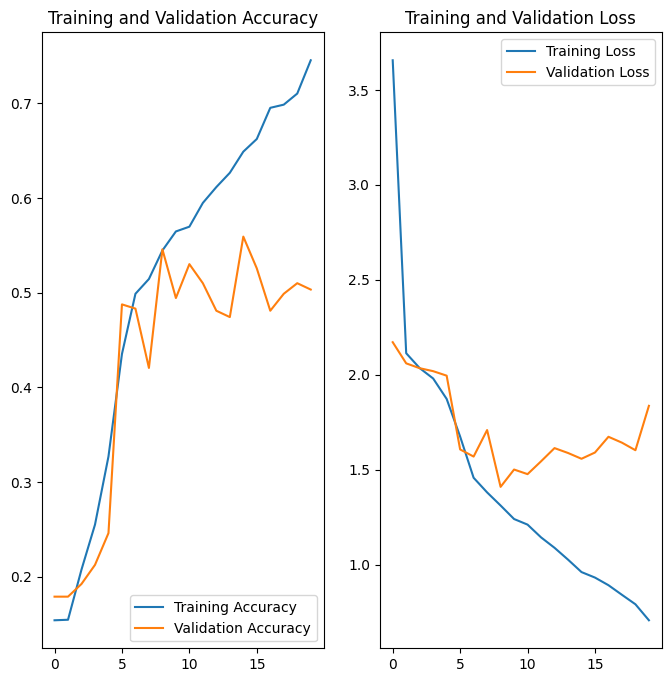

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
y_true=[]
y_pred=[]
for images, labels in test_ds.take(1):
  y_true=list(labels.numpy())
  #y_pred=model.predict_classes(images)
  y_pred=np.argmax(model.predict(images), axis=-1)
  
print(classification_report(y_true,y_pred,target_names=class_names))
print("*"*20)
print("Accuracy on test dataset : ",accuracy_score(y_true,y_pred))

4/4 [==============================] - 1s 114ms/step
                            precision    recall  f1-score   support

         actinic keratosis       0.00      0.00      0.00        16
      basal cell carcinoma       0.31      0.56      0.40        16
            dermatofibroma       0.33      0.06      0.11        16
                  melanoma       0.19      0.19      0.19        16
                     nevus       0.25      0.69      0.37        16
pigmented benign keratosis       0.53      0.62      0.57        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.20      0.06      0.10        16
           vascular lesion       1.00      0.67      0.80         3

                  accuracy                           0.31       118
                 macro avg       0.31      0.32      0.28       118
              weighted avg       0.27      0.31      0.25       118

********************
Accuracy on test dataset :  0.313559322

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
# Now we try the same model with more epochs and different opitmizer

num_classes = 9

model_rmsprop = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    #first conv 2d layer
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Flatten(),
                    Dense(128,activation='relu'),
                    Dense(len(class_names))
])

model_rmsprop.compile(optimizer='rmsprop',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 30
history_rmsprop = model_rmsprop.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 7s 93ms/step - loss: 4.2561 - accuracy: 0.2199 - val_loss: 2.1759 - val_accuracy: 0.2148
Epoch 2/30
56/56 [==============================] - 5s 87ms/step - loss: 1.9719 - accuracy: 0.2974 - val_loss: 1.7974 - val_accuracy: 0.4139
Epoch 3/30
56/56 [==============================] - 5s 90ms/step - loss: 1.8314 - accuracy: 0.3672 - val_loss: 1.7316 - val_accuracy: 0.4183
Epoch 4/30
56/56 [==============================] - 5s 86ms/step - loss: 1.6715 - accuracy: 0.4157 - val_loss: 1.7513 - val_accuracy: 0.3400
Epoch 5/30
56/56 [==============================] - 5s 86ms/step - loss: 1.5924 - accuracy: 0.4420 - val_loss: 1.5491 - val_accuracy: 0.4944
Epoch 6/30
56/56 [==============================] - 5s 88ms/step - loss: 1.4951 - accuracy: 0.4794 - val_loss: 1.4531 - val_accuracy: 0.5101
Epoch 7/30
56/56 [==============================] - 5s 85ms/step - loss: 1.3940 - accuracy: 0.5028 - val_loss: 1.5401 - val_accuracy: 0.4452
Epoch 8/30
56

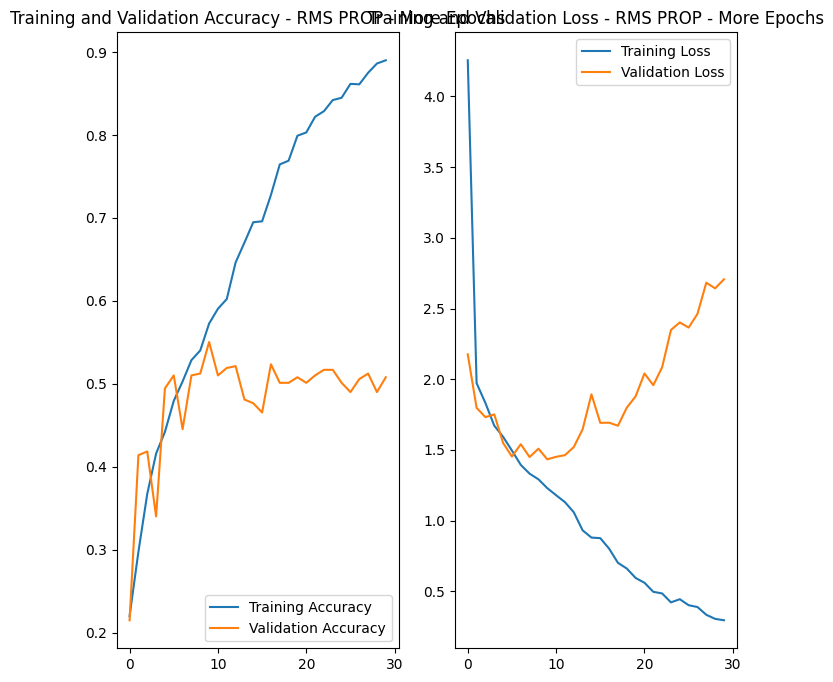

In [20]:
#we visualize the results for the model

acc = history_rmsprop.history['accuracy']
val_acc = history_rmsprop.history['val_accuracy']

loss = history_rmsprop.history['loss']
val_loss = history_rmsprop.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy - RMS PROP - More Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss - RMS PROP - More Epochs')
plt.show()

In [21]:
y_true=[]
y_pred=[]
for images, labels in test_ds.take(1):
  y_true=list(labels.numpy())
  y_pred=np.argmax(model_rmsprop.predict(images), axis=-1)
print(classification_report(y_true,y_pred,target_names=class_names))
print("*"*20)
print("RMS prop Accuracy on test dataset : ",accuracy_score(y_true,y_pred))

4/4 [==============================] - 0s 15ms/step
                            precision    recall  f1-score   support

         actinic keratosis       1.00      0.12      0.22        16
      basal cell carcinoma       0.28      0.31      0.29        16
            dermatofibroma       0.20      0.06      0.10        16
                  melanoma       0.19      0.19      0.19        16
                     nevus       0.28      0.69      0.39        16
pigmented benign keratosis       0.39      0.56      0.46        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.45      0.31      0.37        16
           vascular lesion       0.67      0.67      0.67         3

                  accuracy                           0.32       118
                 macro avg       0.38      0.32      0.30       118
              weighted avg       0.39      0.32      0.29       118

********************
RMS prop Accuracy on test dataset :  0.3

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here
#### **We have trained the same model with different optimizers (adams , rmsprop) and epochs(20 ,30) .We observe that till 6-7 epochs  training and validation accuracy both increase . But after that training accuracy keeps on increasing to 80% whereas validation accuracy keeps fluctuating at 50% . Which means has begun to overfit .**

In [22]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, 
# choose an appropriate data augumentation strategy. 

data_aug = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

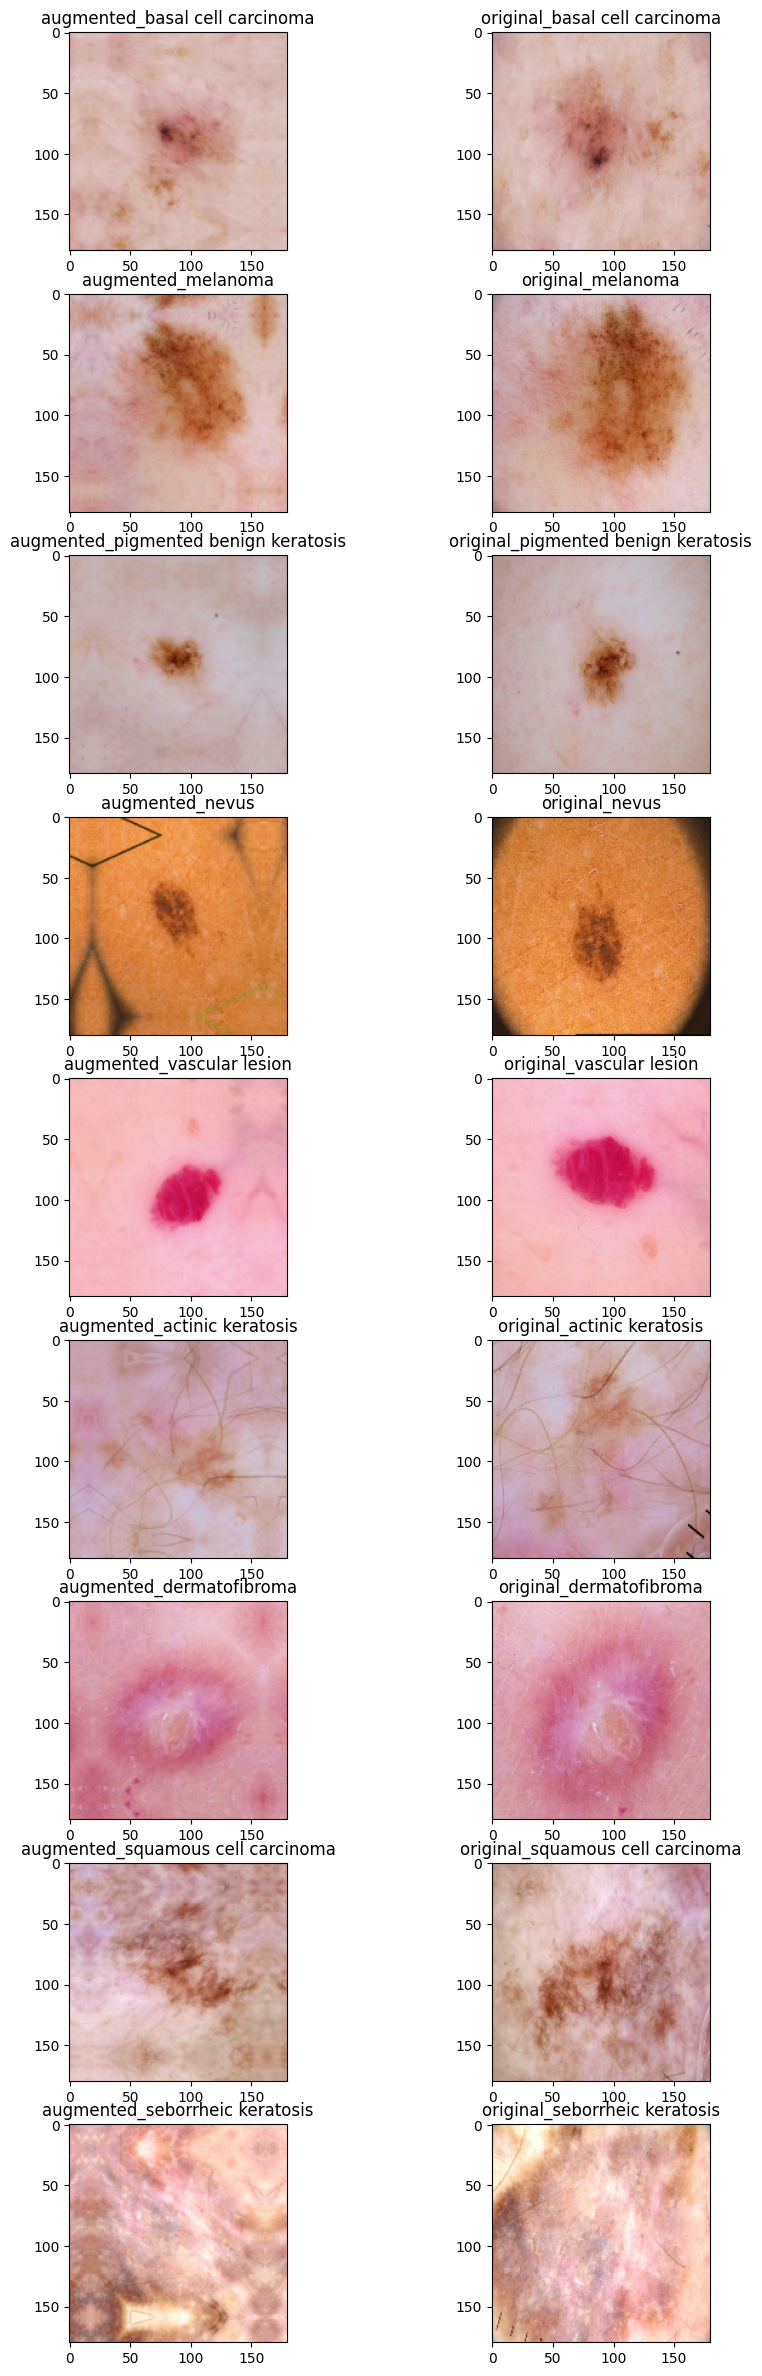

In [23]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plot_idx=0
visited={}
visited_all=False
plt.figure(figsize=(10,30))
for images, labels in train_ds.take(50):
  if not visited_all:
    for i in range(9):
    # print(images," | ",labels)
      # print(images.shape)
      # print(images[0].shape)
      # plt.figure(figsize=(20,20))
      if len(visited.keys())==9:
        visited_all=True
        break
      if class_names[labels[i]] in visited.keys():
        continue
      else:
        plt.subplot(9,2,plot_idx+1)
        x=data_aug(images)
        plt.imshow(x[i].numpy().astype("uint8"));
        # plt.imshow(images[i].numpy().astype("uint8"));
        plt.title("augmented_"+class_names[labels[i]])
        plot_idx+=1
        plt.subplot(9,2,plot_idx+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("original_"+class_names[labels[i]])
        visited[class_names[labels[i]]]="Y"
        plot_idx+=1
        
  else:
    break




### Todo:
### Create the model

In [24]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential([
                    data_aug,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    #first conv 2d layer
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Flatten(),
                    Dense(128,activation='relu'),
                    Dense(len(class_names))
])

### Compiling the model

In [25]:
## Your code goes here
model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_18 (ModuleWr  (None, 180, 180, 64)     1792      
 apper)                                                          
                                                                 
 module_wrapper_19 (ModuleWr  (None, 90, 90, 64)       0         
 apper)                                                          
                                                                 
 module_wrapper_20 (ModuleWr  (None, 90, 90, 64)       0         
 apper)                                                          
                                                      

### Training the model

In [26]:
## Your code goes here, note: train your model for 20 epochs


epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 8s 97ms/step - loss: 4.3577 - accuracy: 0.1696 - val_loss: 2.1799 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 5s 91ms/step - loss: 2.1140 - accuracy: 0.1903 - val_loss: 2.0468 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 5s 93ms/step - loss: 2.0005 - accuracy: 0.2148 - val_loss: 1.9666 - val_accuracy: 0.2416
Epoch 4/20
56/56 [==============================] - 5s 89ms/step - loss: 1.9084 - accuracy: 0.2941 - val_loss: 1.8011 - val_accuracy: 0.3647
Epoch 5/20
56/56 [==============================] - 5s 89ms/step - loss: 1.7919 - accuracy: 0.3605 - val_loss: 1.7470 - val_accuracy: 0.4116
Epoch 6/20
56/56 [==============================] - 5s 92ms/step - loss: 1.6517 - accuracy: 0.4224 - val_loss: 1.7101 - val_accuracy: 0.4072
Epoch 7/20
56/56 [==============================] - 5s 93ms/step - loss: 1.5286 - accuracy: 0.4682 - val_loss: 1.6055 - val_accuracy: 0.4206
Epoch 8/20
56

## Visualizing the results

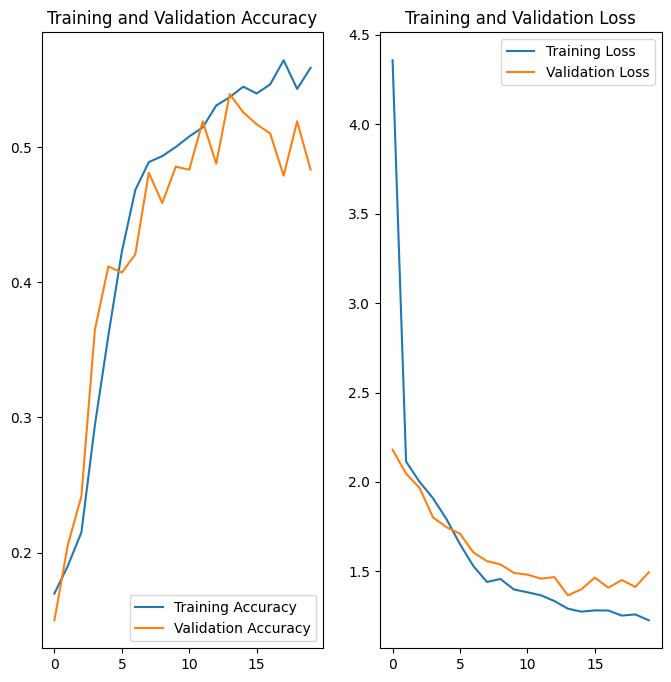

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
# We try with different optimizer
model_aug_adagrad = Sequential([
                    data_aug,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    #first conv 2d layer
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Flatten(),
                    Dense(128,activation='relu'),
                    Dense(len(class_names))
])

model_aug_adagrad.compile(optimizer='adagrad',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 25
history_aug_adagrad = model_aug_adagrad.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
56/56 [==============================] - 8s 100ms/step - loss: 2.0490 - accuracy: 0.2059 - val_loss: 2.0570 - val_accuracy: 0.1924
Epoch 2/25
56/56 [==============================] - 5s 93ms/step - loss: 2.0177 - accuracy: 0.2227 - val_loss: 2.0403 - val_accuracy: 0.2282
Epoch 3/25
56/56 [==============================] - 5s 93ms/step - loss: 1.9997 - accuracy: 0.2600 - val_loss: 2.0238 - val_accuracy: 0.3333
Epoch 4/25
56/56 [==============================] - 5s 94ms/step - loss: 1.9771 - accuracy: 0.2768 - val_loss: 2.0015 - val_accuracy: 0.3490
Epoch 5/25
56/56 [==============================] - 5s 94ms/step - loss: 1.9476 - accuracy: 0.2907 - val_loss: 2.0226 - val_accuracy: 0.2483
Epoch 6/25
56/56 [==============================] - 5s 95ms/step - loss: 1.9172 - accuracy: 0.3153 - val_loss: 1.9366 - val_accuracy: 0.3602
Epoch 7/25
56/56 [==============================] - 5s 96ms/step - loss: 1.8759 - accuracy: 0.3398 - val_loss: 1.9117 - val_accuracy: 0.3982
Epoch 8/25
5

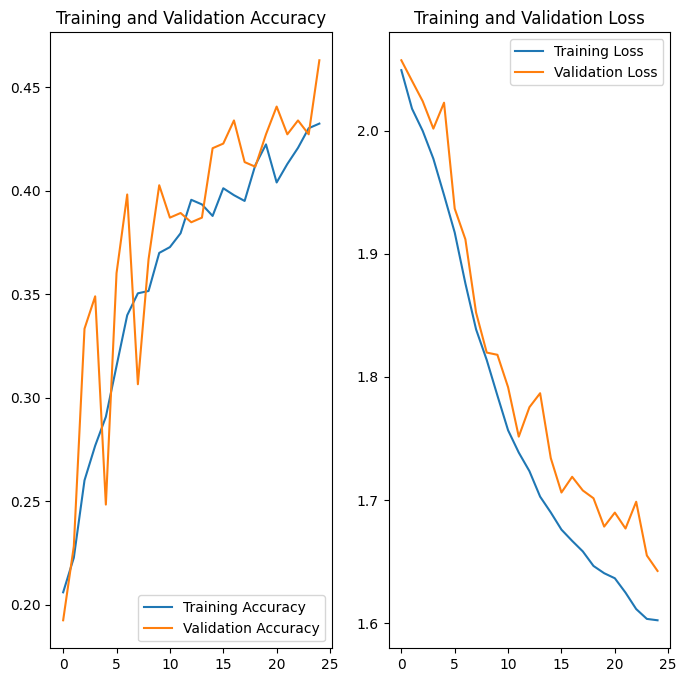

In [29]:
# We create a performance visualisation for adagrad optimiser
acc = history_aug_adagrad.history['accuracy']
val_acc = history_aug_adagrad.history['val_accuracy']

loss = history_aug_adagrad.history['loss']
val_loss = history_aug_adagrad.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
# We create another model with SGD opitmizer
model_aug_sgd = Sequential([
                    data_aug,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    #first conv 2d layer
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Flatten(),
                    Dense(128,activation='relu'),
                    Dense(len(class_names))
])

model_aug_sgd.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 25
history_aug_sgd = model_aug_sgd.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
56/56 [==============================] - 7s 98ms/step - loss: 2.0756 - accuracy: 0.2009 - val_loss: 2.0554 - val_accuracy: 0.2662
Epoch 2/25
56/56 [==============================] - 5s 98ms/step - loss: 2.0023 - accuracy: 0.2467 - val_loss: 2.0319 - val_accuracy: 0.2192
Epoch 3/25
56/56 [==============================] - 5s 96ms/step - loss: 1.9760 - accuracy: 0.2545 - val_loss: 1.9853 - val_accuracy: 0.2013
Epoch 4/25
56/56 [==============================] - 5s 96ms/step - loss: 1.9588 - accuracy: 0.2913 - val_loss: 1.9486 - val_accuracy: 0.2125
Epoch 5/25
56/56 [==============================] - 5s 96ms/step - loss: 1.9200 - accuracy: 0.2941 - val_loss: 1.8686 - val_accuracy: 0.3624
Epoch 6/25
56/56 [==============================] - 5s 95ms/step - loss: 1.8814 - accuracy: 0.3036 - val_loss: 1.9809 - val_accuracy: 0.3199
Epoch 7/25
56/56 [==============================] - 5s 96ms/step - loss: 1.8583 - accuracy: 0.3270 - val_loss: 1.8882 - val_accuracy: 0.3110
Epoch 8/25
56

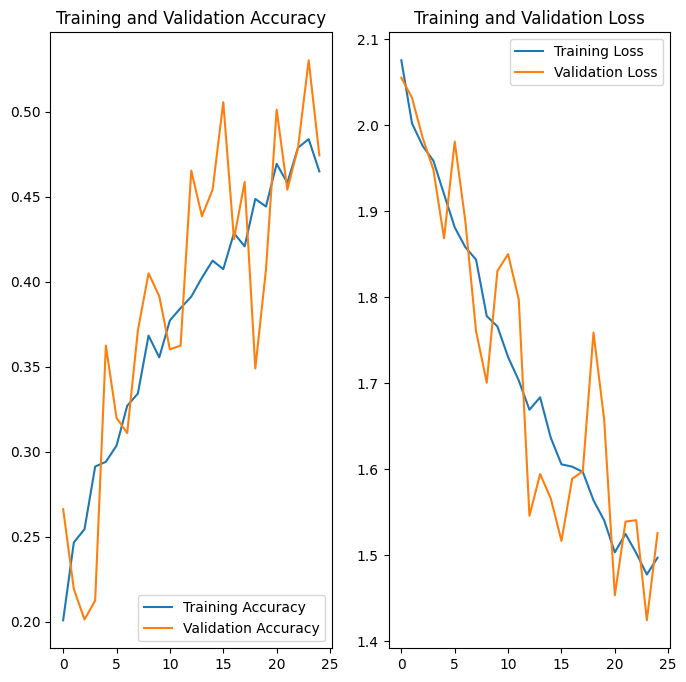

In [31]:
# We create performance visualisation for sgd optimizer
acc = history_aug_sgd.history['accuracy']
val_acc = history_aug_sgd.history['val_accuracy']

loss = history_aug_sgd.history['loss']
val_loss = history_aug_sgd.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
# We check the performance on the test set 
y_true=[]
y_pred=[]
for images, labels in test_ds.take(1):
  y_true=list(labels.numpy())
  
  y_pred=np.argmax(model.predict(images), axis=-1)
  
  print("Adam optimizer")
  print(classification_report(y_true,y_pred,target_names=class_names))
  print("Accuracy on test dataset : ",accuracy_score(y_true,y_pred))
  print("*"*20)
  
  y_pred=np.argmax(model_aug_adagrad.predict(images), axis=-1)
  
  print("Adagrad optimizer")
  print(classification_report(y_true,y_pred,target_names=class_names))
  print("Accuracy on test dataset : ",accuracy_score(y_true,y_pred))
  print("*"*20)
  
  y_pred=np.argmax(model_aug_sgd.predict(images), axis=-1)
  
  print("SGD optimizer")
  print(classification_report(y_true,y_pred,target_names=class_names))
  print("Accuracy on test dataset : ",accuracy_score(y_true,y_pred))
  print("*"*20)

4/4 [==============================] - 0s 14ms/step
Adam optimizer
                            precision    recall  f1-score   support

         actinic keratosis       0.00      0.00      0.00        16
      basal cell carcinoma       0.29      0.38      0.32        16
            dermatofibroma       0.00      0.00      0.00        16
                  melanoma       0.40      0.25      0.31        16
                     nevus       0.36      0.56      0.44        16
pigmented benign keratosis       0.24      0.56      0.33        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.15      0.19      0.17        16
           vascular lesion       0.50      0.67      0.57         3

                  accuracy                           0.28       118
                 macro avg       0.21      0.29      0.24       118
              weighted avg       0.21      0.28      0.23       118

Accuracy on test dataset :  0.2796610169491525

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

4/4 [==============================] - 0s 14ms/step
SGD optimizer
                            precision    recall  f1-score   support

         actinic keratosis       0.00      0.00      0.00        16
      basal cell carcinoma       0.24      0.75      0.37        16
            dermatofibroma       0.00      0.00      0.00        16
                  melanoma       0.27      0.25      0.26        16
                     nevus       0.64      0.88      0.74        16
pigmented benign keratosis       0.21      0.38      0.27        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.00      0.00      0.00        16
           vascular lesion       0.67      0.67      0.67         3

                  accuracy                           0.32       118
                 macro avg       0.22      0.32      0.26       118
              weighted avg       0.20      0.32      0.24       118

Accuracy on test dataset :  0.3220338983050847


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### <u>Findings</u> <b>We observed that after addition of Agumentation layers we were able to reduce the model's overfitting .  However in this case the model is not able to generalise well . We tried out different set of optmizers sgd , adagrad , adams which gave models that had low Training and Validation accuracy. The accuracy figures were between 45-55% both for training and validation . But now the model has begun to overfit.</b>

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [34]:
train_path_list = list(data_dir_train.glob('*/*.jpg'))

In [35]:
df=pd.DataFrame({"cancer_type":[str(x).split("/")[2] for x in train_path_list]})

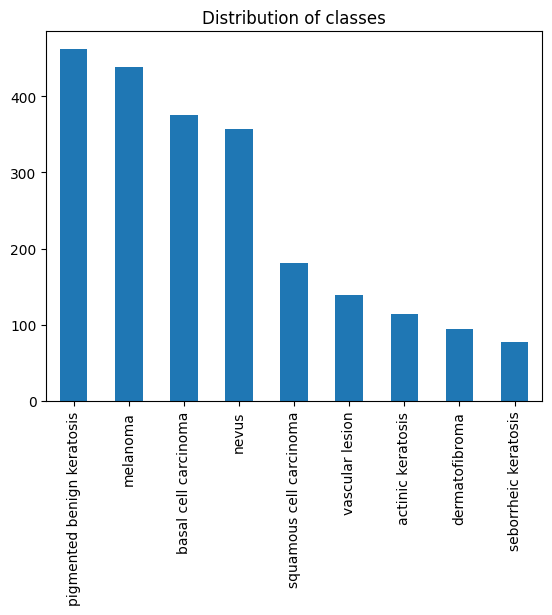

In [36]:
# We look at the distribution of classes
df['cancer_type'].value_counts().plot(kind='bar')
plt.title("Distribution of classes")
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### **Ans : seborrheic keratosis**
#### - Which classes dominate the data in terms proportionate number of samples?
#### <b>Ans : pigmented benign keratosis</b>

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [37]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.

In [38]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F851A4364A0>: 100%|██████████| 500/500 [00:24<00:00, 20.77 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F851A3E1090>: 100%|██████████| 500/500 [00:23<00:00, 21.12 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F85093B0AC0>: 100%|██████████| 500/500 [00:25<00:00, 19.65 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F8509742590>: 100%|██████████| 500/500 [02:00<00:00,  4.14 Samples/s]


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F85102858A0>: 100%|██████████| 500/500 [01:51<00:00,  4.48 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F851A39C940>: 100%|██████████| 500/500 [00:24<00:00, 20.77 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F8510182A40>: 100%|██████████| 500/500 [00:54<00:00,  9.24 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F85B6357F40>: 100%|██████████| 500/500 [00:24<00:00, 20.12 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F85A92D0E50>: 100%|██████████| 500/500 [00:23<00:00, 20.88 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [39]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [40]:
# path list
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [41]:
# lesion list
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]


In [42]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [43]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [44]:
# We created 500 samples for each
df2['Label'].value_counts()

actinic keratosis             500
melanoma                      500
basal cell carcinoma          500
pigmented benign keratosis    500
dermatofibroma                500
seborrheic keratosis          500
nevus                         500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

In [46]:
# we check new counts
new_list=list(df['cancer_type'].values)
new_list.extend(list(df2['Label'].values))
len(new_list)
final_df=pd.DataFrame({"cancer_type":new_list})
final_df['cancer_type'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: cancer_type, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. 

#### **Todo**: Train the model on the data created using Augmentor

In [47]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [48]:
data_dir_train="Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [49]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [50]:
## your code goes here
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    #first conv 2d layer
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.40),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.40),
                    Flatten(),
                    Dense(128,activation='relu'),
                    Dense(len(class_names))
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [51]:
## your code goes here
model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_45 (ModuleWr  (None, 180, 180, 64)     1792      
 apper)                                                          
                                                                 
 module_wrapper_46 (ModuleWr  (None, 90, 90, 64)       0         
 apper)                                                          
                                                                 
 module_wrapper_47 (ModuleWr  (None, 90, 90, 64)       0         
 apper)                                                          
                                                                 
 module_wrapper_48 (ModuleWr  (None, 90, 90, 64)       36928     
 apper)                                               

In [52]:
#### **Todo:**  Train your model

In [53]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 40s 221ms/step - loss: 2.5747 - accuracy: 0.1361 - val_loss: 2.1688 - val_accuracy: 0.1670
Epoch 2/50
169/169 [==============================] - 38s 219ms/step - loss: 1.9813 - accuracy: 0.2448 - val_loss: 1.7534 - val_accuracy: 0.3497
Epoch 3/50
169/169 [==============================] - 36s 207ms/step - loss: 1.5367 - accuracy: 0.4254 - val_loss: 1.4159 - val_accuracy: 0.4878
Epoch 4/50
169/169 [==============================] - 36s 207ms/step - loss: 1.3668 - accuracy: 0.4803 - val_loss: 1.2914 - val_accuracy: 0.5152
Epoch 5/50
169/169 [==============================] - 40s 230ms/step - loss: 1.2148 - accuracy: 0.5462 - val_loss: 1.3307 - val_accuracy: 0.5189
Epoch 6/50
169/169 [==============================] - 41s 238ms/step - loss: 1.1155 - accuracy: 0.5872 - val_loss: 1.1883 - val_accuracy: 0.5679
Epoch 7/50
169/169 [==============================] - 36s 208ms/step - loss: 0.9847 - accuracy: 0.6415 - val_loss: 1.0255 - val_ac

#### **Todo:**  Visualize the model results

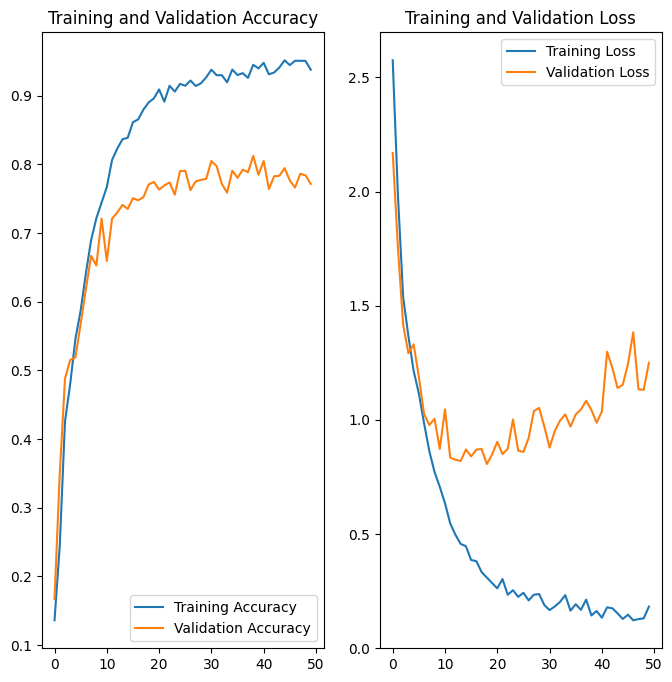

In [54]:
# We plot for ADAM optimizer
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [55]:
# We try with a different model optimizer 
model_imbalance_sgd = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    #first conv 2d layer
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Flatten(),
                    Dense(128,activation='relu'),
                    Dense(len(class_names))
])

model_imbalance_sgd.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 30
## Your code goes here, use 50 epochs.
history_imbalance_sgd = model_imbalance_sgd.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 39s 222ms/step - loss: 2.1691 - accuracy: 0.1632 - val_loss: 2.1397 - val_accuracy: 0.1596
Epoch 2/30
169/169 [==============================] - 38s 219ms/step - loss: 2.0543 - accuracy: 0.2220 - val_loss: 2.0204 - val_accuracy: 0.2376
Epoch 3/30
169/169 [==============================] - 39s 224ms/step - loss: 1.9392 - accuracy: 0.2739 - val_loss: 1.8755 - val_accuracy: 0.2947
Epoch 4/30
169/169 [==============================] - 38s 220ms/step - loss: 1.7889 - accuracy: 0.3338 - val_loss: 1.7582 - val_accuracy: 0.3927
Epoch 5/30
169/169 [==============================] - 36s 209ms/step - loss: 1.6700 - accuracy: 0.3895 - val_loss: 1.5702 - val_accuracy: 0.4105
Epoch 6/30
169/169 [==============================] - 38s 222ms/step - loss: 1.5623 - accuracy: 0.4217 - val_loss: 1.5168 - val_accuracy: 0.4469
Epoch 7/30
169/169 [==============================] - 41s 239ms/step - loss: 1.4984 - accuracy: 0.4531 - val_loss: 1.4927 - val_ac

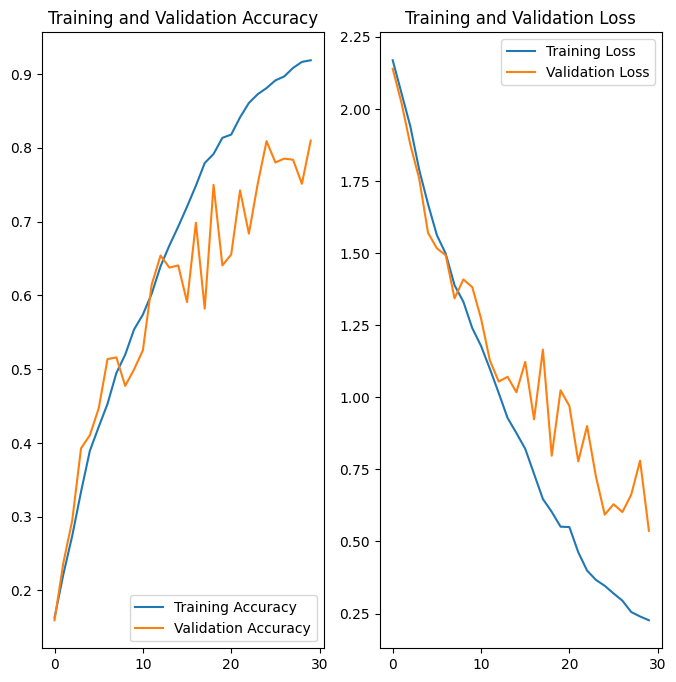

In [56]:
# We plot for SGD optimizer
acc = history_imbalance_sgd.history['accuracy']
val_acc = history_imbalance_sgd.history['val_accuracy']

loss = history_imbalance_sgd.history['loss']
val_loss = history_imbalance_sgd.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [57]:
#trying with a different model 
model_imbalance_adagrad = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    #first conv 2d layer
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Flatten(),
                    Dense(128,activation='relu'),
                    Dense(len(class_names))
])

model_imbalance_adagrad.compile(optimizer='adagrad',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 30

history_imbalance_adagrad = model_imbalance_adagrad.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 40s 221ms/step - loss: 2.1761 - accuracy: 0.1510 - val_loss: 2.1602 - val_accuracy: 0.2480
Epoch 2/30
169/169 [==============================] - 36s 206ms/step - loss: 2.1219 - accuracy: 0.1910 - val_loss: 2.0906 - val_accuracy: 0.2108
Epoch 3/30
169/169 [==============================] - 39s 219ms/step - loss: 2.0211 - accuracy: 0.2517 - val_loss: 1.9784 - val_accuracy: 0.3222
Epoch 4/30
169/169 [==============================] - 40s 232ms/step - loss: 1.9091 - accuracy: 0.2843 - val_loss: 1.8988 - val_accuracy: 0.2925
Epoch 5/30
169/169 [==============================] - 36s 210ms/step - loss: 1.8176 - accuracy: 0.3075 - val_loss: 1.8067 - val_accuracy: 0.3460
Epoch 6/30
169/169 [==============================] - 38s 222ms/step - loss: 1.7516 - accuracy: 0.3355 - val_loss: 1.7850 - val_accuracy: 0.2955
Epoch 7/30
169/169 [==============================] - 36s 208ms/step - loss: 1.6989 - accuracy: 0.3540 - val_loss: 1.7162 - val_ac

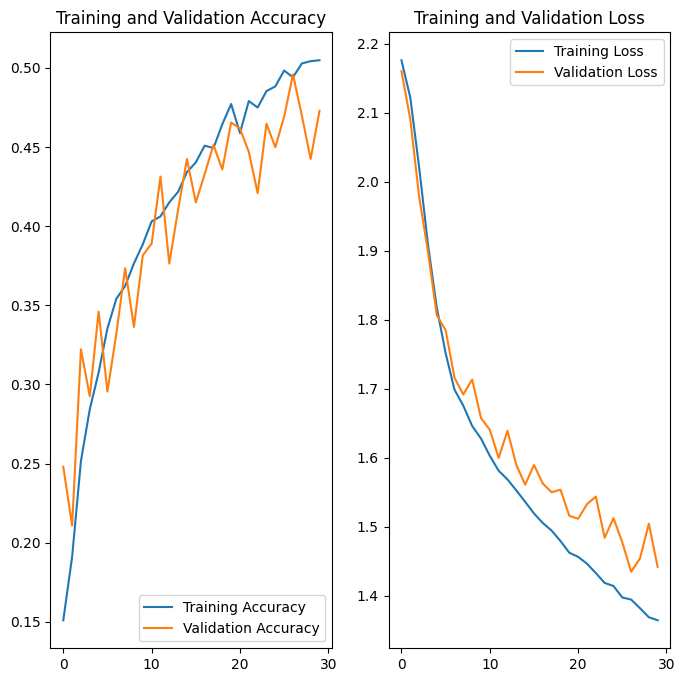

In [58]:
# we visualize for adagrad
acc = history_imbalance_adagrad.history['accuracy']
val_acc = history_imbalance_adagrad.history['val_accuracy']

loss = history_imbalance_adagrad.history['loss']
val_loss = history_imbalance_adagrad.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

So we have tried the model with different epochs (30,50) and optimizers (adam, sgd , adaagrad) .  The initial model with adam optimizer with 50 epochs seems to work well with validation accuracy reaching about 80%.

In [59]:
# We check the performance on the test set 
y_true=[]
y_pred=[]
for images, labels in test_ds.take(1):
  
  y_true=list(labels.numpy())
  y_pred=np.argmax(model.predict(images), axis=-1)
  
  print("Adam optimizer")
  print(classification_report(y_true,y_pred,target_names=class_names))
  print("Accuracy on test dataset : ",accuracy_score(y_true,y_pred))
  print("*"*20)
  y_pred=np.argmax(model_imbalance_adagrad.predict(images), axis=-1)
  
  print("Adagrad optimizer")
  print(classification_report(y_true,y_pred,target_names=class_names))
  print("Accuracy on test dataset : ",accuracy_score(y_true,y_pred))
  print("*"*20)
  y_pred=np.argmax(model_imbalance_sgd.predict(images), axis=-1)
  
  print("SGD optimizer")
  print(classification_report(y_true,y_pred,target_names=class_names))
  print("Accuracy on test dataset : ",accuracy_score(y_true,y_pred))
  print("*"*20)

4/4 [==============================] - 0s 15ms/step
Adam optimizer
                            precision    recall  f1-score   support

         actinic keratosis       0.29      0.12      0.17        16
      basal cell carcinoma       0.42      0.31      0.36        16
            dermatofibroma       0.38      0.19      0.25        16
                  melanoma       0.14      0.12      0.13        16
                     nevus       0.28      0.56      0.38        16
pigmented benign keratosis       0.23      0.38      0.29        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.24      0.25      0.24        16
           vascular lesion       1.00      0.67      0.80         3

                  accuracy                           0.28       118
                 macro avg       0.33      0.29      0.29       118
              weighted avg       0.29      0.28      0.27       118

Accuracy on test dataset :  0.2796610169491525

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                            precision    recall  f1-score   support

         actinic keratosis       0.00      0.00      0.00        16
      basal cell carcinoma       0.30      0.50      0.37        16
            dermatofibroma       0.31      0.25      0.28        16
                  melanoma       0.14      0.06      0.09        16
                     nevus       0.44      0.69      0.54        16
pigmented benign keratosis       0.32      0.38      0.34        16
      seborrheic keratosis       0.22      0.67      0.33         3
   squamous cell carcinoma       0.25      0.06      0.10        16
           vascular lesion       0.17      0.67      0.27         3

                  accuracy                           0.30       118
                 macro avg       0.24      0.36      0.26       118
              weighted avg       0.25      0.30      0.25       118

Accuracy on test dataset :  0.2966101694915254
********************
4/4 [==============================] - 0s 15m

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

<b>We tried different models with optimizers (sgd, adams, adagrad) and epochs (30,50,30) . By adding augmented images which inturn helped in handling class imbalance , we were able to address and mitigate the problem of overfitting . Out of all the models that we evaluated, the performance was decent for the model with Adam's optimizer . The model had a train accuracy of ~90% while the validation accuracy was about ~80% . This model learns rapidly (increase in training and validation accuracy)for the first 20 epochs , but after this the learning becomes slow </b>.